In [149]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [150]:
image = cv2.imread('sar_1.jpg')
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Алгоритм разрастания регионов

In [151]:
import math
def homo_average(img, mask, point, T):
    av_val = img[mask > 0].sum() / np.count_nonzero(img[mask > 0])

    if abs(av_val - img[point]) <= T:
        return True

    return False

In [152]:
def region_growing(image, seed_point,homo_fun,r, T):
    mask = np.zeros(image_gray.shape, np.uint8)
    mask[seed_point] = 1
    count = 1
    while count > 0:
        count = 0
        local_mask = np.zeros(image_gray.shape, np.uint8)
        for i in range(r,image.shape[0] - r):
            for j in range(r,image.shape[1] - r):
                if mask[i,j]==0 and mask[i - r:i + r, j-r: j+r].sum() > 0:
                    if homo_fun(image, mask, (i,j), T):
                        local_mask[i,j] = 1
        count = np.count_nonzero(local_mask)
        print(count)
        mask += local_mask

    return mask*255


# K-means

In [153]:
# Define criteria = ( type, max_iter = 10 , epsilon = 1.0 )
# criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 10, 1.0)

In [154]:
flags = cv2.KMEANS_RANDOM_CENTERS

In [155]:
image_gray_copy = image_gray.copy()
z = image_gray_copy.reshape((-1,3))
# convert to np.float32
z = np.float32(z)
# define criteria, number of clusters(K) and apply kmeans()
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
K = 3
ret,label,center=cv2.kmeans(z,K,None,criteria,10,cv2.KMEANS_RANDOM_CENTERS)
# Now convert back into uint8, and make original image
center = np.uint8(center)
res = center[label.flatten()]
res2 = res.reshape((image_gray_copy.shape))

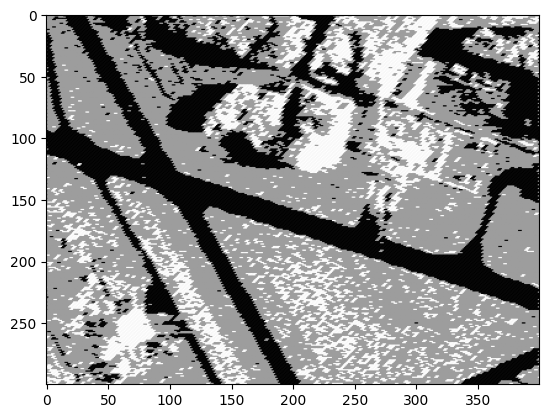

In [156]:
plt.imshow(res2, cmap="gray")

# Watershed+Distance transform

In [157]:
image = cv2.imread('oranges_1.jpg')
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

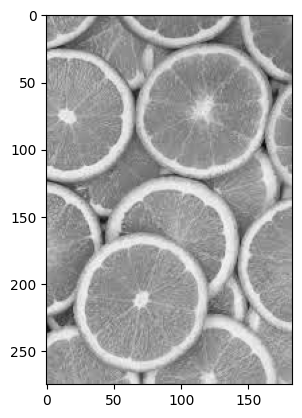

In [158]:
plt.imshow(image_gray, cmap="gray")

In [159]:
ret, thresh = cv2.threshold(image_gray,0,255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

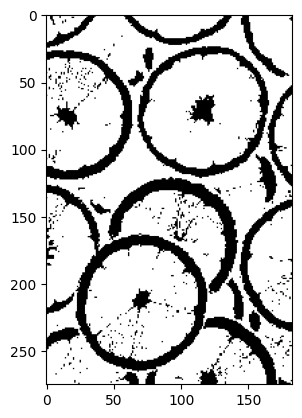

In [160]:
plt.imshow(thresh, cmap="gray")

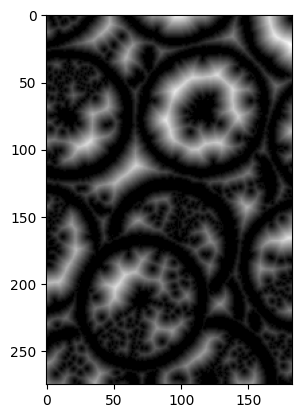

In [161]:
dist = cv2.distanceTransform(thresh, cv2.DIST_L2, 5)
plt.imshow(dist, cmap="gray")

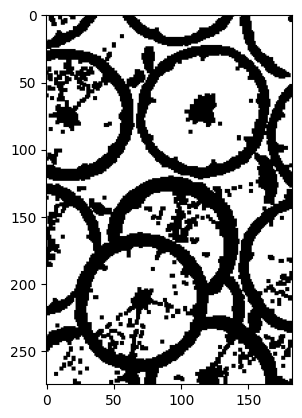

In [162]:
ret, sure_fg = cv2.threshold(dist, 0.1 * dist.max(), 255, cv2.THRESH_BINARY)
plt.imshow(sure_fg, cmap="gray")

In [163]:
sure_fg = sure_fg.astype(np.uint8)

In [164]:
ret, markers = cv2.connectedComponents(sure_fg)

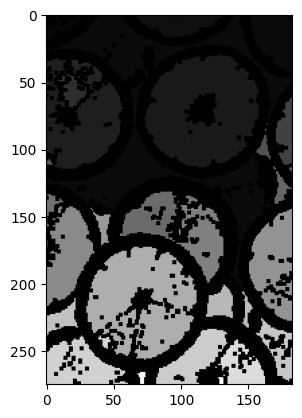

In [165]:
plt.imshow(markers, cmap="gray")

In [166]:
markers = cv2.watershed(image, markers)

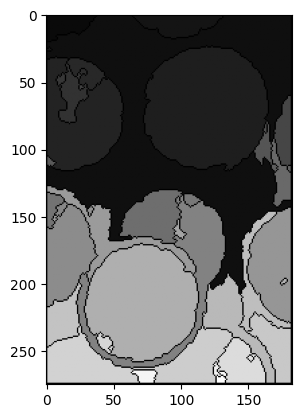

In [167]:
plt.imshow(markers, cmap="gray")

In [168]:
# ДЗ
# 1. Подберите парамтеры алгоритма разрастания регионов так, чтобы был выделен весь участок газона.
# 2. Реализуйте вычисление критерия однородности, отличного от представленного. Сравните результаты.
# 3. Применить алгоритм сегментации watershed+distance transform для задачи подсчета пальмовых деревьев.

## 1. Подберите парамтеры алгоритма разрастания регионов так, чтобы был выделен весь участок газона.

63
160
259
351
447
549
645
745
845
936
1039
889
842
868
860
836
804
769
731
729
682
656
625
589
554
508
479
436
405
383
356
334
307
276
249
225
117
73
57
39
53
0


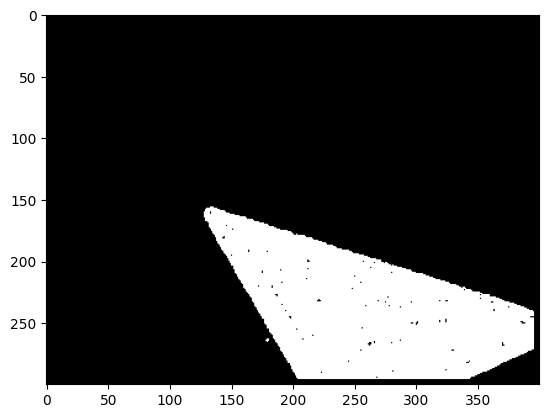

In [169]:
image = cv2.imread('sar_1.jpg')
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

seed_point = (250, 250)
mask_average = region_growing(image_gray, seed_point, homo_average, 4, 25)
plt.imshow(mask_average, cmap="gray")

## 2. Реализуйте вычисление критерия однородности, отличного от представленного. Сравните результаты.

63
160
259
352
448
549
645
745
850
936
1040
883
842
868
860
836
804
780
737
713
682
656
626
589
554
508
479
436
405
383
356
334
307
276
284
227
117
73
58
39
15
0


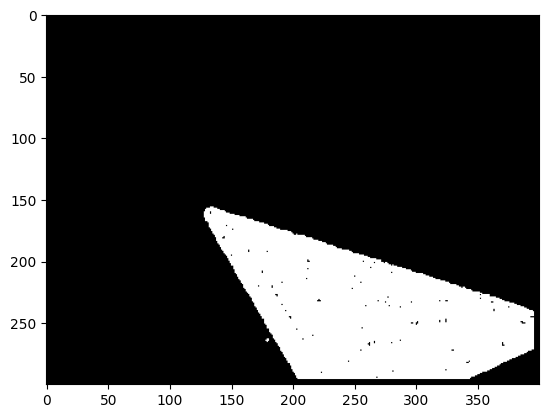

In [170]:
def homo_median(img, mask, point, T):
    region = np.median(img[mask > 0])
    return abs(img[point] - region) <= T

seed_point = (250, 250)
mask_median = region_growing(image_gray, seed_point, homo_median, 4, 25)
plt.imshow(mask_median, cmap="gray")

## 3. Применить алгоритм сегментации watershed+distance transform для задачи подсчета пальмовых деревьев.

In [171]:
image = cv2.imread('palm_1.JPG')
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

blurred = cv2.GaussianBlur(image_gray, (13, 13), 0)

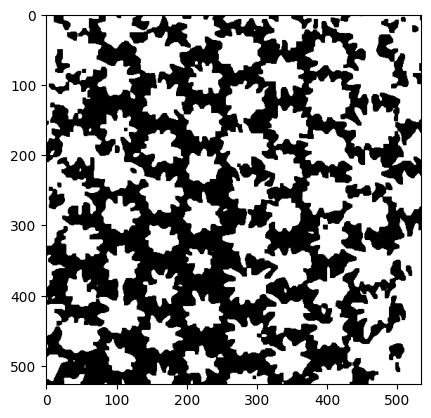

In [172]:
ret, thresh = cv2.threshold(blurred,0,255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

kernel = np.ones((3,3),np.uint8)
thresh = cv2.dilate(thresh, kernel, iterations=2)
thresh = cv2.erode(thresh, kernel, iterations=2)

plt.imshow(thresh, cmap="gray")

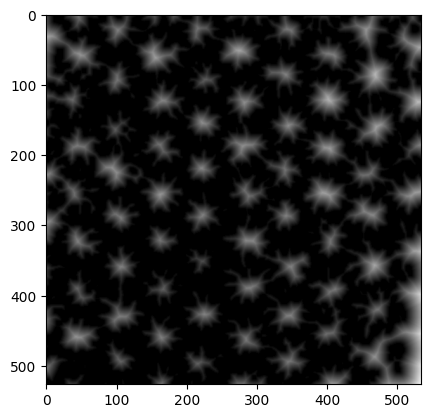

In [173]:
dist = cv2.distanceTransform(thresh, cv2.DIST_L2, 5)
plt.imshow(dist, cmap="gray")

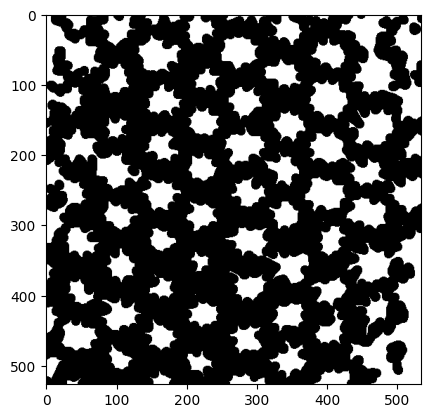

In [174]:
ret, sure_fg = cv2.threshold(dist, 0.12 * dist.max(), 255, cv2.THRESH_BINARY)
plt.imshow(sure_fg, cmap="gray")

In [175]:
sure_fg = np.uint8(sure_fg)

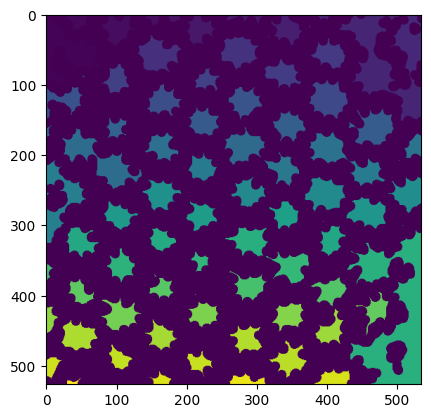

In [176]:
ret, markers = cv2.connectedComponents(sure_fg)

plt.imshow(markers)

In [177]:
markers = cv2.watershed(image, markers)

unique_markers = np.unique(markers)
# Фильтруем границу и бэкграунд
unique_markers = unique_markers[(unique_markers != -1) & (unique_markers != 0)]

print(f"Кол-во пальм: {len(unique_markers)}")

Кол-во пальм: 95
